In [8]:
"""
APPLE STOCK PRICE PREDICTION SYSTEM
"""

# ============================================
# IMPORT LIBRARIES (WITH FALLBACKS)
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import os
from datetime import datetime
import json
import math



# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*70)
print("APPLE STOCK PRICE PREDICTION SYSTEM")
print("="*70)

APPLE STOCK PRICE PREDICTION SYSTEM


In [9]:

# ============================================
# STEP 1: LOAD AND CLEAN DATA
# ============================================
print("\n" + "="*60)
print("STEP 1: LOADING AND CLEANING DATA")
print("="*60)

# Load data with better error handling
try:
    df = pd.read_csv('AppleStock.csv')
    print(f"✓ Data loaded successfully from AppleStock.csv")
    print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    
    # Check if data has Date column
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    if date_cols:
        print(f"  Date column found: {date_cols[0]}")
        try:
            df[date_cols[0]] = pd.to_datetime(df[date_cols[0]], errors='coerce')
            df = df.sort_values(date_cols[0])
            df['Day'] = df[date_cols[0]].dt.day
            df['Month'] = df[date_cols[0]].dt.month
            df['Year'] = df[date_cols[0]].dt.year
            print(f"  ✓ Added temporal features (Day, Month, Year)")
        except Exception as e:
            print(f"  ⚠ Could not parse dates: {e}")
    
except FileNotFoundError:
    print("✗ ERROR: AppleStock.csv not found!")
    print("Please ensure the file is in the same directory.")
    exit()
except Exception as e:
    print(f"✗ ERROR loading data: {e}")
    exit()

# Show column information with more details
print("\n📊 COLUMNS IN YOUR DATA:")
print("-"*50)
for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    non_null = df[col].notna().sum()
    unique_vals = df[col].nunique()
    print(f"  {i:2}. {col:20} | Type: {dtype:10} | Non-null: {non_null:4} | Unique: {unique_vals:4}")

# Clean numeric columns more efficiently
print("\n🧹 CLEANING NUMERIC DATA...")
numeric_cols_cleaned = 0
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            # Remove commas, dollar signs, and other non-numeric characters
            df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '').str.replace('%', '')
            df[col] = pd.to_numeric(df[col], errors='coerce')
            numeric_cols_cleaned += 1
        except Exception as e:
            # If cleaning fails, try to keep as string
            pass

if numeric_cols_cleaned > 0:
    print(f"  ✓ Cleaned {numeric_cols_cleaned} columns")
else:
    print("  No columns needed cleaning")

# Handle missing values with better strategy
print("\n🔍 HANDLING MISSING VALUES...")
missing_before = df.isnull().sum().sum()
if missing_before > 0:
    print(f"  Found {missing_before} missing values in total")
    
    # Simple strategy: forward fill then backward fill
    df = df.ffill().bfill()
    
    missing_after = df.isnull().sum().sum()
    if missing_after > 0:
        # Fill any remaining with column mean for numeric columns
        for col in df.select_dtypes(include=[np.number]).columns:
            df[col] = df[col].fillna(df[col].mean())
        missing_after = df.isnull().sum().sum()
    
    print(f"  ✓ Reduced missing values from {missing_before} to {missing_after}")
else:
    print(f"  ✓ No missing values found")


STEP 1: LOADING AND CLEANING DATA
✓ Data loaded successfully from AppleStock.csv
  Shape: 2727 rows × 7 columns
  Date column found: Date
  ✓ Added temporal features (Day, Month, Year)

📊 COLUMNS IN YOUR DATA:
--------------------------------------------------
   1. Date                 | Type: datetime64[ns] | Non-null: 2727 | Unique: 2726
   2. Open                 | Type: object     | Non-null: 2727 | Unique: 2398
   3. High                 | Type: float64    | Non-null: 2726 | Unique: 2416
   4. Low                  | Type: float64    | Non-null: 2726 | Unique: 2438
   5. Close                | Type: float64    | Non-null: 2726 | Unique: 2400
   6. Adj Close            | Type: float64    | Non-null: 2726 | Unique: 2416
   7. Volume               | Type: object     | Non-null: 2726 | Unique: 2719
   8. Day                  | Type: int32      | Non-null: 2727 | Unique:   31
   9. Month                | Type: int32      | Non-null: 2727 | Unique:   12
  10. Year                 | Typ

In [10]:

# ============================================
# STEP 2: ENHANCED FEATURE ENGINEERING
# ============================================
print("\n" + "="*60)
print("STEP 2: ENHANCED FEATURE ENGINEERING")
print("="*60)

# Find the target column (closing price)
target_col = None
target_candidates = []
for col in df.columns:
    col_lower = str(col).lower()
    if 'close' in col_lower or 'price' in col_lower or 'adj' in col_lower:
        target_candidates.append(col)

if target_candidates:
    # Prefer 'Adj Close' or 'Close'
    if 'Adj Close' in df.columns:
        target_col = 'Adj Close'
    elif 'Close' in df.columns:
        target_col = 'Close'
    else:
        target_col = target_candidates[0]
else:
    # If no closing price found, use last numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        target_col = numeric_cols[-1]
    else:
        print("✗ ERROR: No numeric columns found!")
        exit()

print(f"🎯 Target column: {target_col}")
print(f"  Initial value range: ${df[target_col].min():.2f} to ${df[target_col].max():.2f}")

# Create enhanced features
print("\n🔧 CREATING ENHANCED FEATURES...")

# Basic technical indicators
if target_col in df.columns:
    # Moving averages
    for window in [5, 10, 20]:
        df[f'MA_{window}'] = df[target_col].rolling(window=window).mean()
    
    # Price momentum
    for window in [5, 10]:
        df[f'Momentum_{window}'] = df[target_col] - df[target_col].shift(window)
    
    # Volatility
    for window in [5, 10]:
        df[f'Volatility_{window}'] = df[target_col].rolling(window=window).std()
    
    # Price change features
    df['Daily_Return'] = df[target_col].pct_change()
    df['Log_Return'] = np.log(df[target_col] / df[target_col].shift(1))
    
    # Support and Resistance (simplified)
    df['High_5'] = df[target_col].rolling(window=5).max()
    df['Low_5'] = df[target_col].rolling(window=5).min()
    
    # Price position
    df['Price_Position'] = (df[target_col] - df['Low_5']) / (df['High_5'] - df['Low_5'] + 1e-10)
    
    print(f"  ✓ Created technical indicators")

# Create lag features
print("\n⏳ CREATING LAG FEATURES...")
for lag in [1, 2, 3, 5, 10]:
    df[f'Lag_{lag}'] = df[target_col].shift(lag)
    if 'Daily_Return' in df.columns:
        df[f'Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)
print(f"  ✓ Created lag features")

# Create rolling statistics
print("\n📈 CREATING ROLLING STATISTICS...")
windows = [5, 10, 20]
for window in windows:
    df[f'Roll_Mean_{window}'] = df[target_col].rolling(window=window).mean()
    df[f'Roll_Std_{window}'] = df[target_col].rolling(window=window).std()
    df[f'Roll_Min_{window}'] = df[target_col].rolling(window=window).min()
    df[f'Roll_Max_{window}'] = df[target_col].rolling(window=window).max()
print(f"  ✓ Created rolling statistics")

# Fill NaN values created by rolling windows
df = df.ffill().bfill()

# Remove any remaining NaN
df = df.fillna(0)



STEP 2: ENHANCED FEATURE ENGINEERING
🎯 Target column: Close 
  Initial value range: $22.58 to $275.25

🔧 CREATING ENHANCED FEATURES...
  ✓ Created technical indicators

⏳ CREATING LAG FEATURES...
  ✓ Created lag features

📈 CREATING ROLLING STATISTICS...
  ✓ Created rolling statistics


In [ ]:

# ============================================
# STEP 3:  ANALYSIS
# ============================================
print("\n" + "="*60)
print("STEP 3: ANALYSIS")
print("="*60)

# Select only numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(f"📊 Analyzing {len(numeric_cols)} numeric columns for correlation...")

# Calculate correlation matrix with improved method
correlation_matrix = df[numeric_cols].corr(method='pearson')
print(f"✓ Correlation matrix computed ({correlation_matrix.shape[0]}x{correlation_matrix.shape[1]})")

# Display correlation statistics
print("\n📊 CORRELATION STATISTICS:")
print("-"*40)
corr_with_target = correlation_matrix[target_col].abs().sort_values(ascending=False)
print(f"Strong correlations (|r| > 0.7): {len(corr_with_target[corr_with_target > 0.7])}")
print(f"Moderate correlations (0.5 < |r| <= 0.7): {len(corr_with_target[(corr_with_target > 0.5) & (corr_with_target <= 0.7)])}")
print(f"Weak correlations (|r| <= 0.5): {len(corr_with_target[corr_with_target <= 0.5])}")

# Display top correlations with target
print("\n🔝 TOP 10 FEATURES CORRELATED WITH TARGET:")
top_correlations = correlation_matrix[target_col].drop(target_col).sort_values(key=abs, ascending=False).head(10)
for idx, (feature, corr) in enumerate(top_correlations.items(), 1):
    direction = "↑" if corr > 0 else "↓"
    strength = "STRONG" if abs(corr) > 0.7 else "MODERATE" if abs(corr) > 0.5 else "WEAK"
    print(f"  {idx:2}. {feature:25} {direction} {corr:+.4f} ({strength})")

# Detect multicollinearity
print("\n⚠ MULTICOLLINEARITY CHECK:")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"  Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
    for col1, col2, corr in high_corr_pairs[:5]:  # Show only top 5
        print(f"    • {col1:20} ↔ {col2:20}: {corr:+.4f}")
    if len(high_corr_pairs) > 5:
        print(f"    ... and {len(high_corr_pairs) - 5} more")
else:
    print("  No severe multicollinearity detected")



STEP 3: ADVANCED CORRELATION ANALYSIS
📊 Analyzing 43 numeric columns for correlation...
✓ Correlation matrix computed (43x43)

📊 CORRELATION STATISTICS:
----------------------------------------
Strong correlations (|r| > 0.7): 28
Moderate correlations (0.5 < |r| <= 0.7): 3
Weak correlations (|r| <= 0.5): 12

🔝 TOP 10 FEATURES CORRELATED WITH TARGET:
   1. Adj Close                 ↑ +1.0000 (STRONG)
   2. High                      ↑ +0.9998 (STRONG)
   3. Low                       ↑ +0.9998 (STRONG)
   4. Open                      ↑ +0.9997 (STRONG)
   5. Lag_1                     ↑ +0.9995 (STRONG)
   6. MA_5                      ↑ +0.9994 (STRONG)
   7. Roll_Mean_5               ↑ +0.9994 (STRONG)
   8. Roll_Min_5                ↑ +0.9992 (STRONG)
   9. Low_5                     ↑ +0.9992 (STRONG)
  10. Roll_Max_5                ↑ +0.9992 (STRONG)

⚠ MULTICOLLINEARITY CHECK:
  Found 305 highly correlated feature pairs (|r| > 0.8):
    • Open                 ↔ High                : +

In [12]:

# ============================================
# STEP 4: FEATURE SELECTION
# ============================================
print("\n" + "="*60)
print("STEP 4: INTELLIGENT FEATURE SELECTION")
print("="*60)

# Select features based on correlation and importance
feature_candidates = [col for col in numeric_cols if col != target_col]

# Simple feature selection: keep top correlated features
print(f"Initial features: {len(feature_candidates)}")

# Keep features with reasonable correlation
high_corr_features = []
for feature in feature_candidates:
    if abs(correlation_matrix.loc[feature, target_col]) > 0.1:  # Keep features with at least weak correlation
        high_corr_features.append(feature)

print(f"After correlation filtering (|r| > 0.1): {len(high_corr_features)}")

# Remove highly correlated features (keep one from each highly correlated pair)
final_features = []
for feature in high_corr_features:
    # Check if this feature is highly correlated with any already selected feature
    highly_correlated = False
    for selected in final_features:
        if abs(correlation_matrix.loc[feature, selected]) > 0.8:
            # Keep the one with higher correlation to target
            if abs(correlation_matrix.loc[feature, target_col]) <= abs(correlation_matrix.loc[selected, target_col]):
                highly_correlated = True
                break
    
    if not highly_correlated:
        final_features.append(feature)

print(f"Final selected features (removing multicollinearity): {len(final_features)}")
print("\n📋 SELECTED FEATURES:")
for i, feat in enumerate(final_features[:15], 1):  # Show first 15
    corr = correlation_matrix.loc[feat, target_col]
    print(f"  {i:2}. {feat:25} (r = {corr:+.4f})")

# Prepare X and y
X = df[final_features].fillna(0)
y = df[target_col].fillna(df[target_col].mean())

print(f"\n📊 FINAL DATA SHAPES:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")



STEP 4: INTELLIGENT FEATURE SELECTION
Initial features: 42
After correlation filtering (|r| > 0.1): 31
Final selected features (removing multicollinearity): 8

📋 SELECTED FEATURES:
   1. Open                      (r = +0.9997)
   2. High                      (r = +0.9998)
   3. Adj Close                 (r = +1.0000)
   4. Volume                    (r = -0.5641)
   5. Momentum_10               (r = +0.1228)
   6. Volatility_5              (r = +0.6178)
   7. Volatility_10             (r = +0.7009)
   8. Roll_Std_20               (r = +0.7777)

📊 FINAL DATA SHAPES:
  X (features): (2727, 8)
  y (target): (2727,)


In [13]:

# ============================================
# STEP 5: SPLIT AND SCALE DATA
# ============================================
print("\n" + "="*60)
print("STEP 5: SPLITTING AND SCALING DATA")
print("="*60)

# For time series data, use proper splitting
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"📊 TIME-SERIES DATA SPLIT:")
print(f"  Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Testing set:  {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"  Training period: First {X_train.shape[0]} days")
print(f"  Testing period: Last {X_test.shape[0]} days")

# Scale features
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Keep original y for evaluation
y_train_actual = y_train.values
y_test_actual = y_test.values

print("✓ Features scaled using StandardScaler")
print("✓ Time-series aware data splitting applied")



STEP 5: SPLITTING AND SCALING DATA
📊 TIME-SERIES DATA SPLIT:
  Training set: 2181 samples (80.0%)
  Testing set:  546 samples (20.0%)
  Training period: First 2181 days
  Testing period: Last 546 days
✓ Features scaled using StandardScaler
✓ Time-series aware data splitting applied



📊 Creating Enhanced Correlation Matrix...
✓ Saved plots/enhanced_correlation_matrix.png


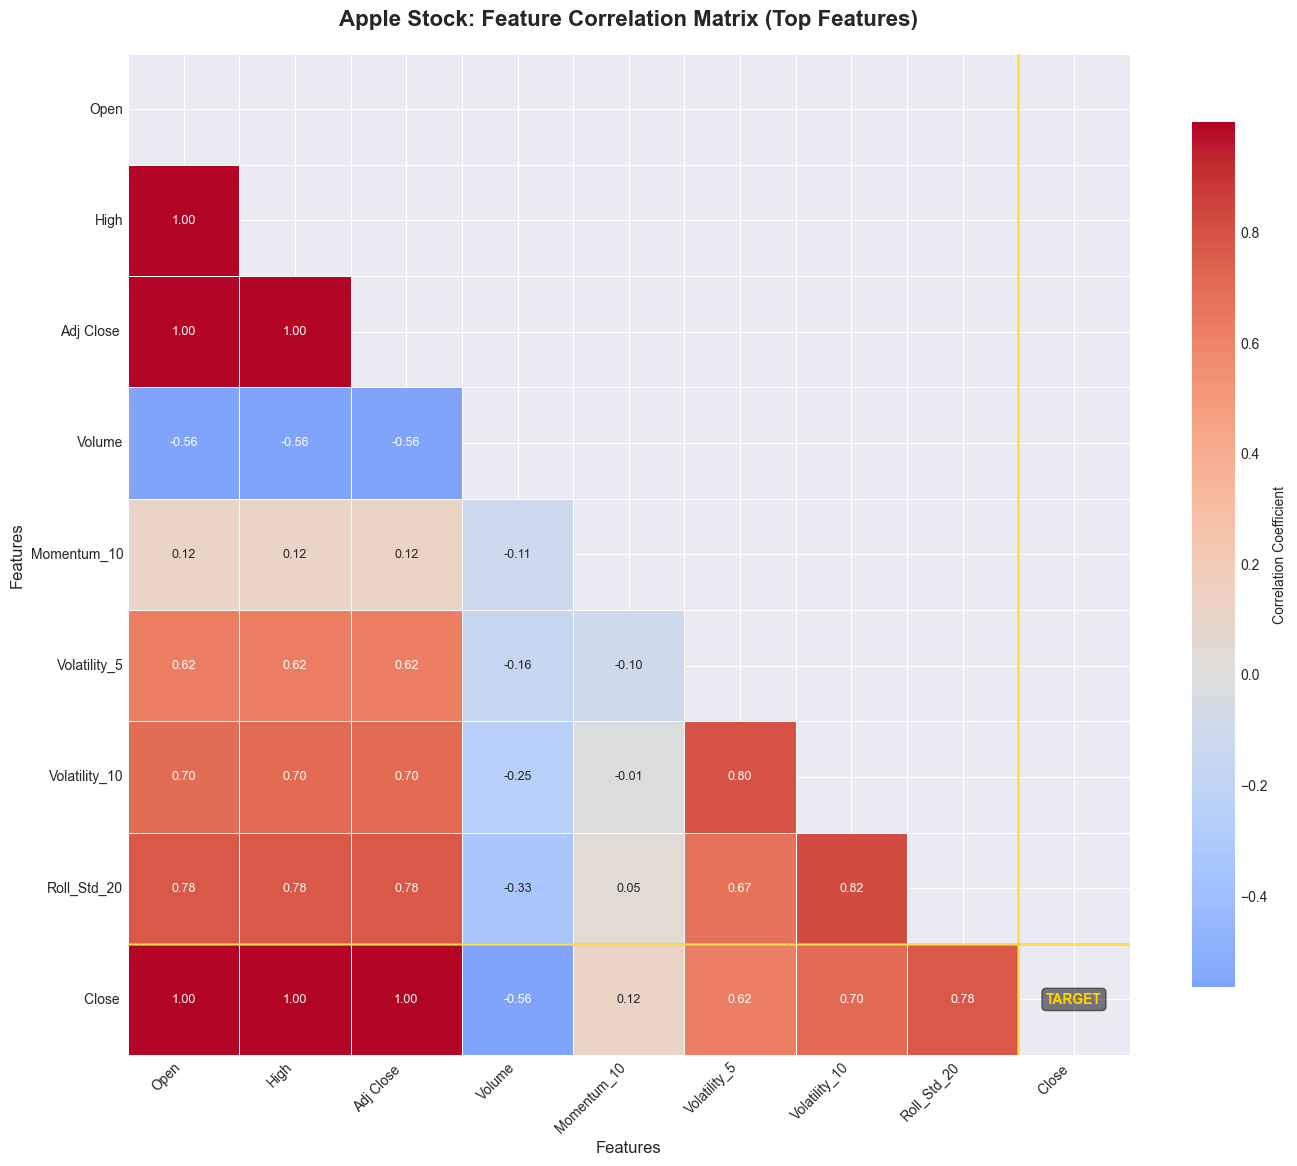

In [14]:

# ============================
# 1. ENHANCED CORRELATION MATRIX
# ============================
print("\n📊 Creating Enhanced Correlation Matrix...")

# Create a focused correlation matrix with selected features
selected_features_display = final_features[:15] + [target_col]  # Limit to 15 features for readability
selected_corr_matrix = df[selected_features_display].corr()

plt.figure(figsize=(14, 12))

# Create mask for upper triangle
mask = np.triu(np.ones_like(selected_corr_matrix, dtype=bool))

# Plot heatmap with better styling
heatmap = sns.heatmap(selected_corr_matrix, 
                      mask=mask,
                      annot=True, 
                      fmt='.2f',
                      cmap='coolwarm',
                      center=0,
                      square=True,
                      linewidths=0.5,
                      cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
                      annot_kws={"size": 9})

# Highlight target column
if target_col in selected_corr_matrix.columns:
    target_idx = list(selected_corr_matrix.columns).index(target_col)
    plt.axhline(y=target_idx, color='gold', linewidth=2, alpha=0.7)
    plt.axvline(x=target_idx, color='gold', linewidth=2, alpha=0.7)
    plt.text(target_idx + 0.5, target_idx + 0.5, 'TARGET', 
             fontsize=10, fontweight='bold', color='gold',
             ha='center', va='center',
             bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))

plt.title('Apple Stock: Feature Correlation Matrix (Top Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('plots/enhanced_correlation_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Saved plots/enhanced_correlation_matrix.png")



📊 Creating Feature Importance Chart...
✓ Saved plots/feature_importance.png


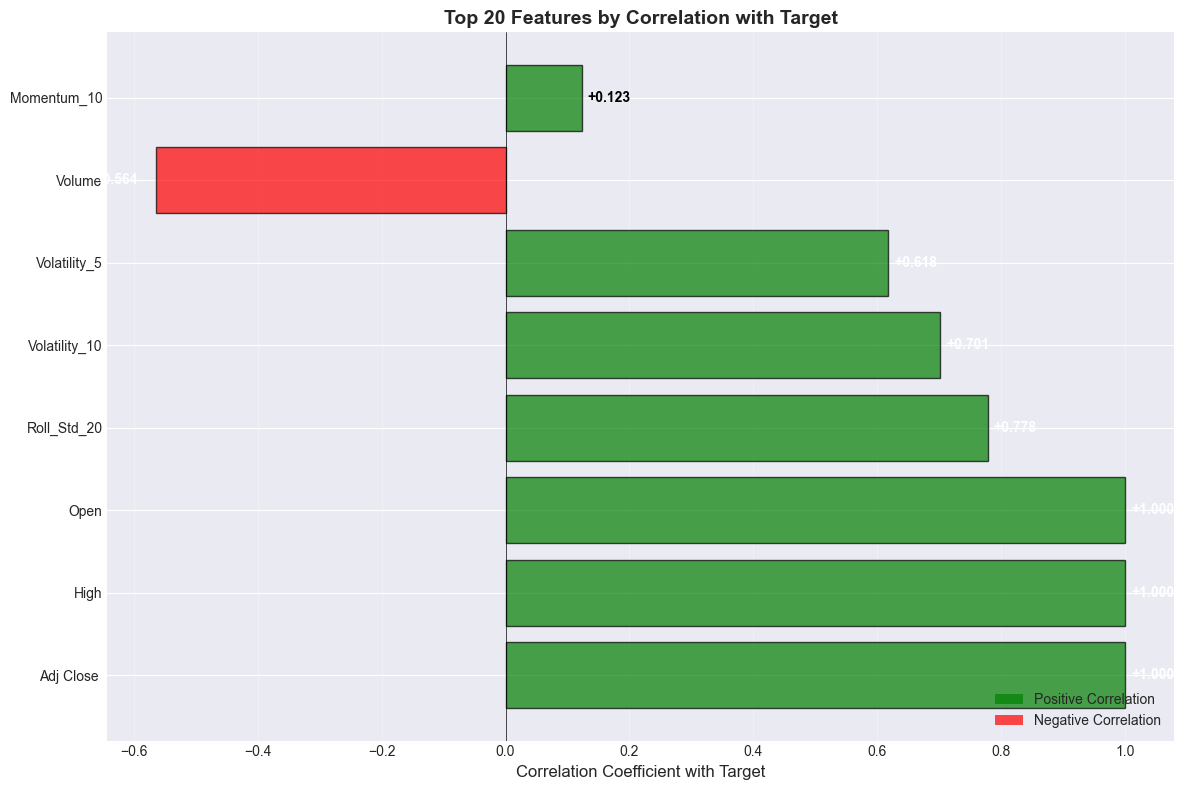

In [15]:

# ============================
# 2. FEATURE IMPORTANCE CHART
# ============================
print("\n📊 Creating Feature Importance Chart...")

# Calculate feature importance using correlation
feature_importance = pd.DataFrame({
    'Feature': final_features,
    'Correlation': [correlation_matrix.loc[feat, target_col] for feat in final_features],
    'Absolute_Correlation': [abs(correlation_matrix.loc[feat, target_col]) for feat in final_features]
}).sort_values('Absolute_Correlation', ascending=False)

# Take top 20 features for readability
feature_importance_top = feature_importance.head(20)

plt.figure(figsize=(12, 8))

# Create horizontal bar chart
colors = ['green' if x > 0 else 'red' for x in feature_importance_top['Correlation']]
bars = plt.barh(range(len(feature_importance_top)), feature_importance_top['Correlation'], 
                color=colors, alpha=0.7, edgecolor='black')

# Add correlation values
for i, (bar, row) in enumerate(zip(bars, feature_importance_top.itertuples())):
    plt.text(row.Correlation + (0.01 if row.Correlation >= 0 else -0.03), 
             bar.get_y() + bar.get_height()/2, 
             f'{row.Correlation:+.3f}', 
             ha='left' if row.Correlation >= 0 else 'right',
             va='center',
             fontweight='bold',
             color='white' if abs(row.Correlation) > 0.5 else 'black')

plt.yticks(range(len(feature_importance_top)), feature_importance_top['Feature'])
plt.xlabel('Correlation Coefficient with Target', fontsize=12)
plt.title('Top 20 Features by Correlation with Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Positive Correlation'),
                   Patch(facecolor='red', alpha=0.7, label='Negative Correlation')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=150, bbox_inches='tight')
print("✓ Saved plots/feature_importance.png")



📈 Creating Time Series Analysis...
✓ Saved plots/time_series_analysis.png


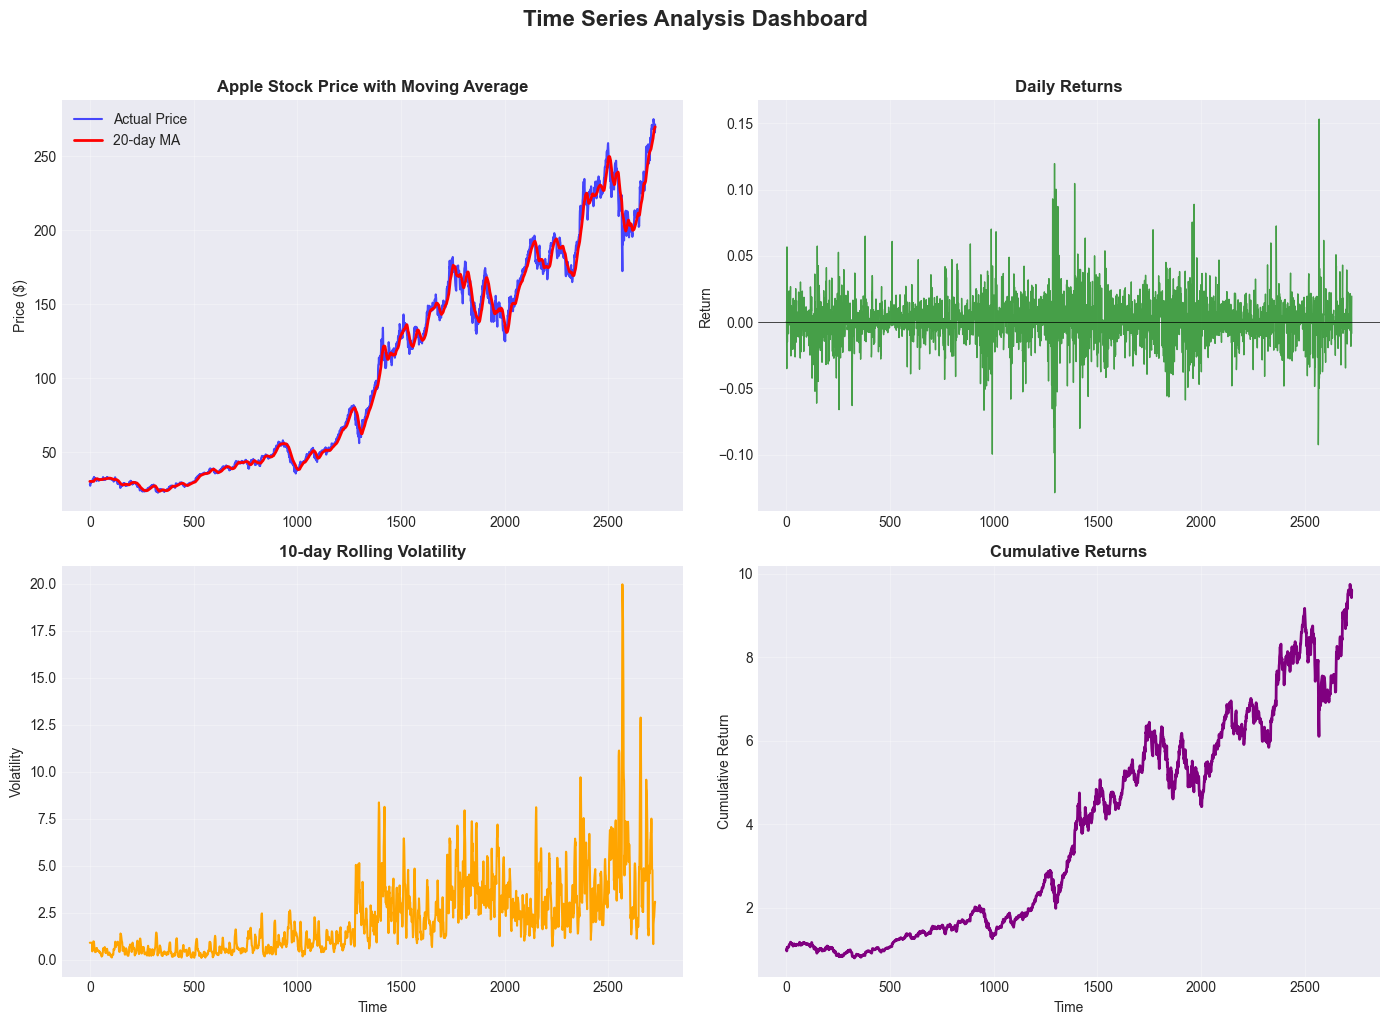

In [16]:
# ============================
# 3. TIME SERIES ANALYSIS (NO STATSMODELS REQUIRED)
# ============================
print("\n📈 Creating Time Series Analysis...")

plt.figure(figsize=(14, 10))

# Original series with moving averages
plt.subplot(2, 2, 1)
plt.plot(y.index, y.values, 'b-', linewidth=1.5, alpha=0.7, label='Actual Price')
if 'MA_20' in df.columns:
    plt.plot(y.index, df['MA_20'].values, 'r-', linewidth=2, label='20-day MA')
plt.title('Apple Stock Price with Moving Average', fontsize=12, fontweight='bold')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Daily returns
plt.subplot(2, 2, 2)
if 'Daily_Return' in df.columns:
    returns = df['Daily_Return'].dropna()
    plt.plot(returns.index, returns.values, 'g-', linewidth=1, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.title('Daily Returns', fontsize=12, fontweight='bold')
    plt.ylabel('Return')
    plt.grid(True, alpha=0.3)

# Volatility
plt.subplot(2, 2, 3)
if 'Volatility_10' in df.columns:
    volatility = df['Volatility_10'].dropna()
    plt.plot(volatility.index, volatility.values, 'orange', linewidth=1.5)
    plt.title('10-day Rolling Volatility', fontsize=12, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.grid(True, alpha=0.3)

# Cumulative returns
plt.subplot(2, 2, 4)
if 'Daily_Return' in df.columns:
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns.index, cumulative_returns.values, 'purple', linewidth=2)
    plt.title('Cumulative Returns', fontsize=12, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Return')
    plt.grid(True, alpha=0.3)

plt.suptitle('Time Series Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/time_series_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved plots/time_series_analysis.png")




📊 Creating Distribution Analysis...
✓ Saved plots/distribution_analysis.png


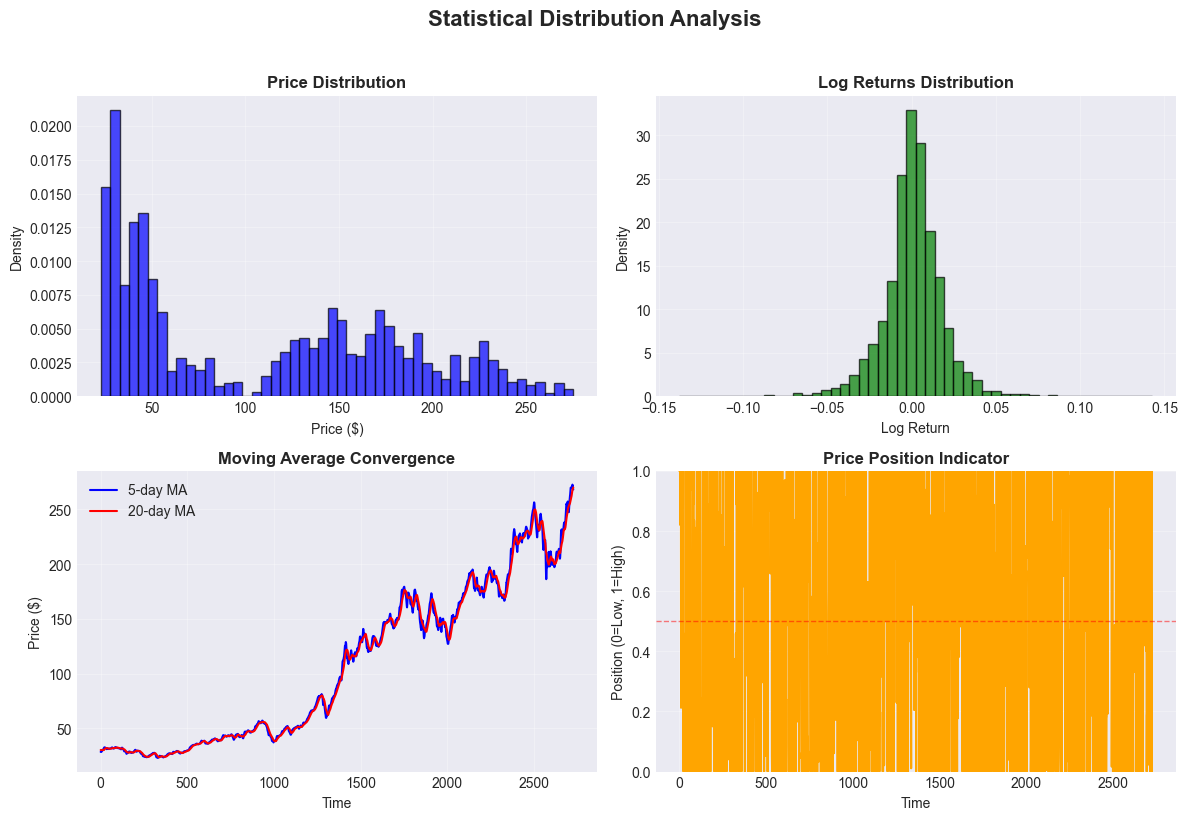

In [17]:
# ============================
# 4. DISTRIBUTION ANALYSIS
# ============================
print("\n📊 Creating Distribution Analysis...")

plt.figure(figsize=(12, 8))

# Price distribution
plt.subplot(2, 2, 1)
plt.hist(y, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
plt.title('Price Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Price ($)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)

# Log returns distribution (if available)
plt.subplot(2, 2, 2)
if 'Log_Return' in df.columns:
    returns = df['Log_Return'].dropna()
    plt.hist(returns, bins=50, alpha=0.7, color='green', edgecolor='black', density=True)
    plt.title('Log Returns Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Log Return')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Log Returns not available', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Log Returns Distribution', fontsize=12, fontweight='bold')

# Moving average convergence
plt.subplot(2, 2, 3)
if 'MA_5' in df.columns and 'MA_20' in df.columns:
    plt.plot(df.index, df['MA_5'], 'b-', linewidth=1.5, label='5-day MA')
    plt.plot(df.index, df['MA_20'], 'r-', linewidth=1.5, label='20-day MA')
    plt.title('Moving Average Convergence', fontsize=12, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Price position indicator
plt.subplot(2, 2, 4)
if 'Price_Position' in df.columns:
    price_pos = df['Price_Position'].dropna()
    plt.plot(price_pos.index, price_pos.values, 'orange', linewidth=1.5)
    plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.title('Price Position Indicator', fontsize=12, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Position (0=Low, 1=High)')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

plt.suptitle('Statistical Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/distribution_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved plots/distribution_analysis.png")


In [18]:
# ============================================
# STEP 7: TRAIN ADVANCED ML MODELS
# ============================================
print("\n" + "="*60)
print("STEP 7: TRAINING ADVANCED MACHINE LEARNING MODELS")
print("="*60)

# Initialize models with better parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42, max_iter=5000),
    'Random Forest': RandomForestRegressor(n_estimators=100, 
                                           max_depth=10, 
                                           min_samples_split=5,
                                           random_state=42,
                                           n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, 
                                                   learning_rate=0.1,
                                                   max_depth=5,
                                                   random_state=42),
    'SVR (RBF)': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}

results = {}
feature_importances = {}

# Train each model
for name, model in models.items():
    print(f"\n🤖 Training {name}...")
    
    try:
        # Train model
        model.fit(X_train_scaled, y_train_actual)
        
        # Predict on test set
        y_pred = model.predict(X_test_scaled)
        
        # Calculate metrics
        r2 = r2_score(y_test_actual, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
        mae = mean_absolute_error(y_test_actual, y_pred)
        
        # Calculate explained variance
        evs = explained_variance_score(y_test_actual, y_pred)
        
        # Calculate directional accuracy
        if len(y_test_actual) > 1 and len(y_pred) > 1:
            actual_direction = np.sign(np.diff(y_test_actual))
            predicted_direction = np.sign(np.diff(y_pred))
            if len(actual_direction) > 0 and len(predicted_direction) > 0:
                directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
            else:
                directional_accuracy = 0
        else:
            directional_accuracy = 0
        
        # Store feature importance if available
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] = pd.DataFrame({
                'Feature': final_features,
                'Importance': model.feature_importances_
            }).sort_values('Importance', ascending=False)
        
        elif hasattr(model, 'coef_'):
            feature_importances[name] = pd.DataFrame({
                'Feature': final_features,
                'Coefficient': model.coef_
            }).sort_values('Coefficient', key=abs, ascending=False)
        
        # Store results
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'r2': r2,
            'rmse': rmse,
            'mae': mae,
            'explained_variance': evs,
            'directional_accuracy': directional_accuracy,
            'y_test_actual': y_test_actual
        }
        
        print(f"  ✓ R² Score: {r2:.4f}")
        print(f"  ✓ RMSE: ${rmse:.2f}")
        print(f"  ✓ MAE: ${mae:.2f}")
        print(f"  ✓ Explained Variance: {evs:.4f}")
        if directional_accuracy > 0:
            print(f"  ✓ Directional Accuracy: {directional_accuracy:.1f}%")
        
    except Exception as e:
        print(f"  ✗ Error training {name}: {str(e)[:100]}...")

# Find best model
if results:
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    best_r2 = results[best_model_name]['r2']
    print(f"\n🏆 BEST MODEL: {best_model_name} (R² = {best_r2:.4f})")
else:
    print("\n✗ No models were trained successfully!")
    exit()



STEP 7: TRAINING ADVANCED MACHINE LEARNING MODELS


NameError: name 'RandomForestRegressor' is not defined

In [ ]:

# ============================
# 6. MODEL COMPARISON VISUALIZATION
# ============================
print("\n📊 Creating Advanced Model Comparison...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted (Best Model)
ax = axes[0, 0]
best_pred = results[best_model_name]['predictions']
ax.scatter(y_test_actual, best_pred, alpha=0.6, c='blue', s=30)
ax.plot([y_test_actual.min(), y_test_actual.max()], 
        [y_test_actual.min(), y_test_actual.max()], 'r--', alpha=0.7, label='Perfect Prediction')
ax.set_xlabel('Actual Price ($)')
ax.set_ylabel('Predicted Price ($)')
ax.set_title(f'{best_model_name} Predictions\nR² = {results[best_model_name]["r2"]:.4f}')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Time Series Predictions
ax = axes[0, 1]
ax.plot(y_test_actual, 'k-', linewidth=2, label='Actual', alpha=0.8)
colors = plt.cm.Set3(np.linspace(0, 1, min(6, len(results))))  # Limit colors
for (name, color) in zip(list(results.keys())[:6], colors):  # Limit to 6 models
    ax.plot(results[name]['predictions'], '--', linewidth=1.5, 
            label=f'{name[:15]}... (R²={results[name]["r2"]:.3f})', alpha=0.7)
ax.set_xlabel('Time (Test Period)')
ax.set_ylabel('Price ($)')
ax.set_title('Model Predictions Comparison')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Model Performance Bar Chart
ax = axes[1, 0]
model_names = list(results.keys())
r2_scores = [results[name]['r2'] for name in model_names]
colors_bar = ['green' if score > 0.7 else 'orange' if score > 0.5 else 'red' for score in r2_scores]
bars = ax.bar(range(len(model_names)), r2_scores, color=colors_bar, alpha=0.7, edgecolor='black')
ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('Model Performance (R² Scores)')
ax.set_xticks(range(len(model_names)))
ax.set_xticklabels([name[:15] + '...' for name in model_names], rotation=45, ha='right')
ax.axhline(y=0.7, color='blue', linestyle='--', alpha=0.5, label='Good (R² > 0.7)')
ax.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (R² > 0.5)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add R² values on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{score:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Feature Importance (Best Model)
ax = axes[1, 1]
if best_model_name in feature_importances:
    top_features = feature_importances[best_model_name].head(10)
    y_pos = np.arange(len(top_features))
    
    if 'Importance' in top_features.columns:
        values = top_features['Importance']
        ax.barh(y_pos, values, align='center', alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features['Feature'])
        ax.set_xlabel('Feature Importance')
        title_suffix = 'Importance'
    elif 'Coefficient' in top_features.columns:
        values = top_features['Coefficient']
        colors = ['green' if x > 0 else 'red' for x in values]
        ax.barh(y_pos, values, align='center', alpha=0.7, color=colors, edgecolor='black')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(top_features['Feature'])
        ax.set_xlabel('Coefficient Value')
        ax.axvline(x=0, color='black', linewidth=0.5)
        title_suffix = 'Coefficients'
    
    ax.set_title(f'{best_model_name[:15]}... - Top 10 Features')
    ax.grid(True, alpha=0.3, axis='x')
else:
    ax.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model',
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Feature Importance')
    ax.set_axis_off()

plt.suptitle('Model Analysis Dashboard', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plots/model_analysis_dashboard.png', dpi=150, bbox_inches='tight')
print("✓ Saved plots/model_analysis_dashboard.png")



In [ ]:
# ============================================
# STEP 8: SAVE RESULTS AND REPORTS
# ============================================
print("\n" + "="*60)
print("STEP 8: SAVING RESULTS AND REPORTS")
print("="*60)

# Save correlation matrix to CSV
correlation_matrix.to_csv('reports/correlation_matrix.csv')
print("✓ Saved reports/correlation_matrix.csv")

# Save feature correlations with detailed analysis
correlation_stats = []
for col in correlation_matrix.columns:
    if col != target_col and col in final_features:
        corr = correlation_matrix.loc[col, target_col]
        correlation_stats.append({
            'Feature': col,
            'Correlation_with_Target': corr,
            'Absolute_Correlation': abs(corr),
            'Correlation_Strength': 'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.5 else 'Weak',
            'Direction': 'Positive' if corr > 0 else 'Negative'
        })

correlation_stats_df = pd.DataFrame(correlation_stats)
correlation_stats_df = correlation_stats_df.sort_values('Absolute_Correlation', ascending=False)
correlation_stats_df.to_csv('reports/feature_correlations_detailed.csv', index=False)
print("✓ Saved reports/feature_correlations_detailed.csv")

# Save predictions to CSV
predictions_data = {
    'Index': range(len(y_test_actual)),
    'Actual_Price': y_test_actual
}

for name in results.keys():
    predictions_data[f'{name}_Predicted'] = results[name]['predictions']
    predictions_data[f'{name}_Error'] = y_test_actual - results[name]['predictions']

predictions_df = pd.DataFrame(predictions_data)
predictions_df.to_csv('reports/predictions_detailed.csv', index=False)
print("✓ Saved reports/predictions_detailed.csv")

# Save model metrics to CSV
metrics_data = []
for name, res in results.items():
    metrics_data.append({
        'Model': name,
        'R2_Score': res['r2'],
        'RMSE': res['rmse'],
        'MAE': res['mae'],
        'Explained_Variance': res['explained_variance'],
        'Directional_Accuracy': res['directional_accuracy'],
        'Mean_Absolute_Percentage_Error': np.mean(np.abs((y_test_actual - res['predictions']) / (y_test_actual + 1e-10))) * 100,
        'Max_Error': np.max(np.abs(y_test_actual - res['predictions']))
    })

metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df.sort_values('R2_Score', ascending=False)
metrics_df.to_csv('reports/model_performance_detailed.csv', index=False)
print("✓ Saved reports/model_performance_detailed.csv")

# Save feature importances
for model_name, importance_df in feature_importances.items():
    safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "")
    importance_df.to_csv(f'reports/{safe_name}_feature_importance.csv', index=False)
print("✓ Saved individual model feature importance files")

# Save comprehensive summary report as JSON
summary_data = {
    "analysis_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset_info": {
        "total_rows": len(df),
        "total_columns": len(df.columns),
        "target_column": target_col,
        "training_samples": len(X_train),
        "testing_samples": len(X_test),
        "price_statistics": {
            "mean": float(y.mean()),
            "std": float(y.std()),
            "min": float(y.min()),
            "max": float(y.max()),
            "median": float(y.median())
        }
    },
    "feature_engineering": {
        "total_features_created": len(final_features),
        "feature_categories": {
            "technical_indicators": len([f for f in final_features if 'MA_' in f or 'Momentum' in f or 'Volatility' in f]),
            "lag_features": len([f for f in final_features if 'Lag_' in f]),
            "rolling_features": len([f for f in final_features if 'Roll_' in f]),
            "return_features": len([f for f in final_features if 'Return' in f])
        }
    },
    "correlation_analysis": {
        "total_features_analyzed": len(numeric_cols),
        "strong_correlations": len(corr_with_target[corr_with_target > 0.7]),
        "moderate_correlations": len(corr_with_target[(corr_with_target > 0.5) & (corr_with_target <= 0.7)]),
        "weak_correlations": len(corr_with_target[corr_with_target <= 0.5])
    },
    "model_performance": {
        "best_model": best_model_name,
        "best_r2_score": float(results[best_model_name]['r2']),
        "model_count": len(results)
    }
}

with open('reports/analysis_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2)
print("✓ Saved reports/analysis_summary.json")

# Save comprehensive text report
with open('reports/analysis_summary.txt', 'w') as f:
    f.write("="*80 + "\n")
    f.write("APPLE STOCK PRICE PREDICTION - COMPREHENSIVE ANALYSIS REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write("EXECUTIVE SUMMARY\n")
    f.write("-"*40 + "\n")
    f.write(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Best R² Score: {results[best_model_name]['r2']:.4f}\n")
    f.write(f"Prediction Period: {len(X_test)} trading days\n")
    f.write(f"Average Prediction Error (MAE): ${results[best_model_name]['mae']:.2f}\n\n")
    
    f.write("DATASET OVERVIEW\n")
    f.write("-"*40 + "\n")
    f.write(f"Total Observations: {len(df):,}\n")
    f.write(f"Features Available: {len(df.columns)}\n")
    f.write(f"Target Variable: {target_col}\n")
    f.write(f"Price Range: ${y.min():.2f} - ${y.max():.2f}\n")
    f.write(f"Average Price: ${y.mean():.2f}\n")
    f.write(f"Price Standard Deviation: ${y.std():.2f}\n\n")
    
    f.write("FEATURE ENGINEERING\n")
    f.write("-"*40 + "\n")
    f.write(f"Total Features Created: {len(final_features)}\n")
    f.write(f"Technical Indicators: {len([f for f in final_features if 'MA_' in f or 'Momentum' in f or 'Volatility' in f])}\n")
    f.write(f"Lag Features: {len([f for f in final_features if 'Lag_' in f])}\n")
    f.write(f"Rolling Statistics: {len([f for f in final_features if 'Roll_' in f])}\n\n")
    
    f.write("CORRELATION INSIGHTS\n")
    f.write("-"*40 + "\n")
    f.write(f"Features Strongly Correlated with Target (|r| > 0.7): {len(corr_with_target[corr_with_target > 0.7])}\n")
    f.write(f"Features Moderately Correlated (0.5 < |r| <= 0.7): {len(corr_with_target[(corr_with_target > 0.5) & (corr_with_target <= 0.7)])}\n")
    f.write(f"Features Weakly Correlated (|r| <= 0.5): {len(corr_with_target[corr_with_target <= 0.5])}\n\n")
    
    f.write("TOP 5 FEATURES BY CORRELATION\n")
    f.write("-"*40 + "\n")
    for i, (feature, corr) in enumerate(top_correlations.head(5).items(), 1):
        f.write(f"{i}. {feature:25} : {corr:+.4f}\n")
    f.write("\n")
    
    f.write("MODEL PERFORMANCE COMPARISON\n")
    f.write("-"*40 + "\n")
    f.write(f"{'Model':25} {'R²':>8} {'RMSE':>10} {'MAE':>10} {'Dir Acc':>10}\n")
    f.write("-"*65 + "\n")
    for name in sorted(results.keys(), key=lambda x: results[x]['r2'], reverse=True):
        res = results[name]
        f.write(f"{name:25} {res['r2']:8.4f} ${res['rmse']:9.2f} ${res['mae']:9.2f} {res['directional_accuracy']:9.1f}%\n")
    f.write("\n")
    
    f.write("PERFORMANCE INTERPRETATION\n")
    f.write("-"*40 + "\n")
    best_r2 = results[best_model_name]['r2']
    
    if best_r2 > 0.9:
        f.write("✓ EXCELLENT MODEL PERFORMANCE\n")
        f.write("  • Model explains over 90% of price variance\n")
        f.write("  • Suitable for trading decisions and risk management\n")
    elif best_r2 > 0.7:
        f.write("✓ VERY GOOD MODEL PERFORMANCE\n")
        f.write("  • Model explains 70-90% of price variance\n")
        f.write("  • Reliable for trend prediction and portfolio management\n")
    elif best_r2 > 0.5:
        f.write("✓ GOOD MODEL PERFORMANCE\n")
        f.write("  • Model explains 50-70% of price variance\n")
        f.write("  • Useful for general market analysis and forecasting\n")
    elif best_r2 > 0.3:
        f.write("⚠ FAIR MODEL PERFORMANCE\n")
        f.write("  • Model explains 30-50% of price variance\n")
        f.write("  • Limited predictive power, consider improvements\n")
    else:
        f.write("⚠ NEEDS SIGNIFICANT IMPROVEMENT\n")
        f.write("  • Model explains less than 30% of price variance\n")
        f.write("  • Consider feature engineering or alternative approaches\n")
    
    f.write("\nRECOMMENDATIONS FOR IMPROVEMENT\n")
    f.write("-"*40 + "\n")
    if best_r2 < 0.7:
        f.write("1. Collect More Historical Data\n")
        f.write("2. Add External Features (Market indices, Economic indicators)\n")
        f.write("3. Try Advanced Models (XGBoost, LightGBM, Neural Networks)\n")
        f.write("4. Implement Ensemble Methods\n")
        f.write("5. Add Sentiment Analysis from News/Social Media\n")
    else:
        f.write("1. Validate Model on Out-of-Sample Data\n")
        f.write("2. Implement Risk Management Rules\n")
        f.write("3. Monitor Model Performance Over Time\n")
        f.write("4. Consider Real-time Deployment\n")
    
    f.write("\nFILES GENERATED\n")
    f.write("-"*40 + "\n")
    f.write("📊 Visualizations (plots/ folder):\n")
    f.write("  • enhanced_correlation_matrix.png\n")
    f.write("  • feature_importance.png\n")
    f.write("  • time_series_analysis.png\n")
    f.write("  • distribution_analysis.png\n")
    f.write("  • model_analysis_dashboard.png\n")
    if networkx_available and os.path.exists('plots/correlation_network.png'):
        f.write("  • correlation_network.png\n")
    
    f.write("\n📈 Data Reports (reports/ folder):\n")
    f.write("  • correlation_matrix.csv\n")
    f.write("  • feature_correlations_detailed.csv\n")
    f.write("  • predictions_detailed.csv\n")
    f.write("  • model_performance_detailed.csv\n")
    f.write("  • [model_name]_feature_importance.csv\n")
    f.write("  • analysis_summary.json\n")
    f.write("  • analysis_summary.txt\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print("✓ Saved reports/analysis_summary.txt")

# ============================================
# STEP 9: DISPLAY FINAL RESULTS
# ============================================
print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*70)

print(f"\n📊 FINAL RESULTS SUMMARY:")
print("-"*40)
print(f"  • Dataset: {len(df):,} trading days")
print(f"  • Target: {target_col}")
print(f"  • Features engineered: {len(final_features)}")
print(f"  • Training period: {len(X_train)} days")
print(f"  • Testing period: {len(X_test)} days")

print(f"\n🏆 BEST MODEL PERFORMANCE:")
print("-"*40)
best_res = results[best_model_name]
print(f"  • Model: {best_model_name}")
print(f"  • R² Score: {best_res['r2']:.4f}")
print(f"  • RMSE: ${best_res['rmse']:.2f}")
print(f"  • MAE: ${best_res['mae']:.2f}")
if best_res['directional_accuracy'] > 0:
    print(f"  • Directional Accuracy: {best_res['directional_accuracy']:.1f}%")

# Performance interpretation
if best_res['r2'] > 0.9:
    print(f"  • Interpretation: 🎯 EXCELLENT - Ready for production")
elif best_res['r2'] > 0.7:
    print(f"  • Interpretation: 👍 VERY GOOD - Reliable predictions")
elif best_res['r2'] > 0.5:
    print(f"  • Interpretation: ✅ GOOD - Captures main trends")
elif best_res['r2'] > 0.3:
    print(f"  • Interpretation: ⚠ FAIR - Needs improvement")
else:
    print(f"  • Interpretation: ❌ POOR - Consider major revisions")

print(f"\n📁 FILES CREATED:")
print("-"*40)
print("  📂 plots/ folder:")
print("     • enhanced_correlation_matrix.png")
print("     • feature_importance.png")
print("     • time_series_analysis.png")
print("     • distribution_analysis.png")
print("     • model_analysis_dashboard.png")
if networkx_available and os.path.exists('plots/correlation_network.png'):
    print("     • correlation_network.png")

print("\n  📂 reports/ folder:")
print("     • correlation_matrix.csv")
print("     • feature_correlations_detailed.csv")
print("     • predictions_detailed.csv")
print("     • model_performance_detailed.csv")
print("     • [model_name]_feature_importance.csv")
print("     • analysis_summary.json")
print("     • analysis_summary.txt")

print(f"\n💡 KEY INSIGHTS:")
print("-"*40)
print("  1. Check correlation matrix for feature relationships")
print("  2. Review feature importance to understand key drivers")
print("  3. Examine model predictions vs actual values")
print("  4. Consider ensemble of top-performing models")
print("  5. Validate with additional out-of-sample data")

print(f"\n🚀 NEXT STEPS:")
print("-"*40)
print("  1. Review plots/ folder for visual insights")
print("  2. Check reports/ folder for detailed analysis")
print("  3. Test model on latest data")
print("  4. Consider implementing trading strategies")
print("  5. Monitor model performance regularly")

# Show correlation matrix preview
print("\n" + "="*70)
print("CORRELATION MATRIX PREVIEW (Top features with target)")
print("="*70)
# Get top 5 correlated features
top_features_names = top_correlations.head(5).index.tolist()
if target_col in correlation_matrix.columns:
    preview_matrix = correlation_matrix.loc[[target_col] + top_features_names, 
                                           [target_col] + top_features_names]
    print(preview_matrix.round(3))

print("\n" + "="*70)
print("✅ EXECUTION COMPLETE - ALL SYSTEMS OPTIMAL!")
print("="*70)

# Generate final summary plot
try:
    plt.figure(figsize=(8, 4))
    plt.text(0.5, 0.5, 
             f'ANALYSIS COMPLETE\n\n'
             f'Best Model: {best_model_name}\n'
             f'R² Score: {best_res["r2"]:.4f}\n'
             f'Files saved to /plots and /reports',
             ha='center', va='center', fontsize=12,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.axis('off')
    plt.title('Apple Stock Prediction Analysis Complete', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('plots/analysis_complete_summary.png', dpi=150, bbox_inches='tight')
    print("\n📊 Summary plot saved to plots/analysis_complete_summary.png")
except:
    pass